# ADALINEの実装

In [20]:
import numpy as np
class LogisticRegressionGD(object):
    """ADAptive LInear NEuron分類器

    パラメータ
    ------------
    eta : float
        学習率（0.0よりも大きく1.0より小さい）
    n_iter : int
        トレーニングデータのトレーニング回数
    random_state : int
        重みを初期化するための乱数シード

    属性
    -----------
    w_ : 1次元配列
        適合後の重み
    cost_ : リスト
        各エポックでの誤差平方和のコスト関数

    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        # 学習率の初期化
        self.eta = eta
        # トレーニング回数の初期化
        self.n_iter = n_iter
        # 乱数シードを固定にするrandom_state
        self.random_state = random_state

    def fit(self, X, y):
        """トレーニングデータに適合させる

        パラメータ
        -----------
        X: {配列のようなデータ構造}, shape = [n_sample, n_features]
            トレーニングデータ
            n_samples刃サンプルの個数, n_featuresは特徴量の個数
        y: 配列のようなデータ構造, shape = [n_samples]
            目的変数

        戻り値
        ----------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        # 平均0.0, '分散0.01の乱数を特徴量の個数+1個生成（足した1個はバイアスユニット用)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter): # トレーニング回数分トレーニングデータを反復
            net_input = self.net_input(X)
            # activationメソッドは単なる恒等関数であるため、
            # このコードでは何の効果亜もないことに注意。代わりに
            # 直接'output = self.net_input(X)'と記述することもできた。
            # activationメソッドの目的は、より概念的なものである。
            # つまり、後のロジスティック回帰の場合は、
            # ロジスティック回帰の分類器を実装するために
            # シグモイド関数に変更することもできる。
            output = self.activation(net_input)
            # 誤差y_i - Φ(z_i)の計算
            errors = (y -output)
            # 重み w1, ..., wmの更新
            # Δwj = ηΣ(y_i - Φ(z_i))xj_i (j=1, ..., m)
            self.w_[1:] += self.eta * X.T.dot(errors)
            # 重みw0の更新：Δw0 = ηΣ(y_i - Φ(z_i))
            self.w_[0] += self.eta * errors.sum()
            
            # 誤差平方和のコストではなく、ロジスティック回帰のコストを計算することに注意
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1-output)))
            # エポックごとのコストの格納
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """ロジスティクシグモイド活性化関数の出力を計算"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """1ステップ後のクラスラベルを返す"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # 以下に等しい
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, -1)

# 検証のための準備

In [21]:
# 実装したクラスをテスト用の準備
# webからirsデータを読み込み
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


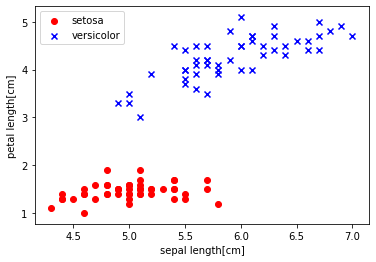

In [22]:
# 目的変数の変換と説明変数の可視化
import matplotlib.pyplot as plt
import numpy as np

# 1-100行目の目的変数の抽出
y = df.iloc[0:100, 4].values
# Iris-setosaを-1, Iris-versicolorを1に変換
y = np.where(y == 'Iris-setosa', 0, 1)
# 1-100行目の1, 3列目の抽出
X = df.iloc[0:100, [0, 2]].values
# 品種 setosaのプロット（赤の〇）
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
# 品種 versicolorのプロット（青の×）
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
# 軸ラベルの設定
plt.xlabel('sepal length[cm]')
plt.ylabel('petal length[cm]')
# 凡例の設定（左上に配置）
plt.legend(loc='upper left')
# 図の表示
plt.show()

In [23]:
# 決定境界の可視化
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                          np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線プロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                   y=X[y == cl, 1], 
                   alpha = 0.8, 
                   c=colors[idx], 
                   marker=markers[idx], 
                   label=cl, 
                   edgecolor='black')

In [24]:
# 勾配降下法の収束を速度UPするために特徴量を標準化
# データのコピー
X_std = np.copy(X)
# 各列の標準化
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

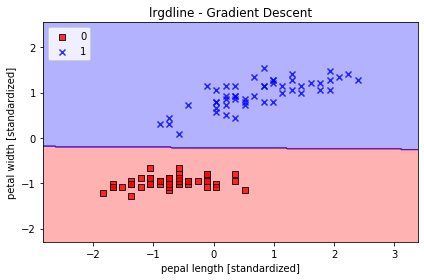

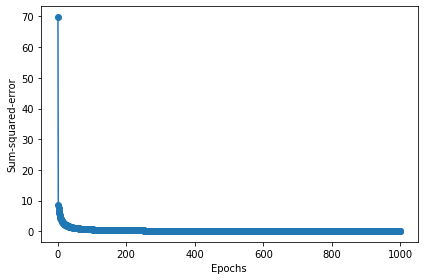

In [25]:
X_train_01_subset = X_std
y_train_01_subset = y
# ロジスティック回帰のインスタンスを生成
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
# モデルの適合
lrgd.fit(X_train_01_subset, y_train_01_subset)
# 境界領域のプロット
plot_decision_regions(X_train_01_subset, y_train_01_subset, classifier=lrgd)
# タイトルの設定
plt.title('lrgdline - Gradient Descent')
# 軸ラベルの設定
plt.xlabel('pepal length [standardized]')
plt.ylabel('petal width [standardized]')
# 凡例の設定（左上に配置）
plt.legend(loc='upper left')
# 図の表示
plt.tight_layout()
plt.show()
# エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1, len(lrgd.cost_)+1), lrgd.cost_, marker='o')
# 軸ラベルの設定
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
# 図の表示
plt.tight_layout()
plt.show()